<a href="https://colab.research.google.com/github/risg99/MGMA-Presentation/blob/main/Python_GraphX_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>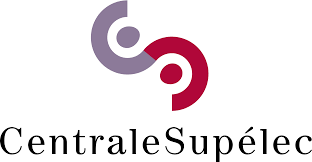</center>

<hr style=" border:none; height:3px;">
<center> <font size="7" color='black'> GraphX Tutorial </font></center>
<font size="3" color='#91053d'>

<center>
Alaa ALMUTAWA, Jezula GAGA, Rishika GUPTA <br>
Under the guidance of: Nacera SEGHOUANI
</center>
</font>   
<hr style=" border:none; height:3px;">

# 1. Installation

To make the tutorial simpler to execute for everyone, there are all the installation commands shared below. Please execute them.

In [1]:
# Installing libraries
!pip install -q "git+https://github.com/PHPirates/graphframes.git@add-setup.py#egg=graphframes&subdirectory=python"
!pip install -q pyspark==3.2.0
!pip install -q networkx

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 9.0 MB/s eta 0:00:00


Verifying the installation

In [2]:
!pip show pyspark
!pip show graphframes

Name: pyspark
Version: 3.2.0
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: py4j
Required-by: 
Name: graphframes
Version: 0.8.2
Summary: 
Home-page: 
Author: 
Author-email: 
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 


Get the correct jars required for graphframes.

In [3]:
!curl -L -o "/usr/local/lib/python3.10/dist-packages/pyspark/jars/graphframes-0.8.2-spark3.2-s_2.12.jar" http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   164  100   164    0     0   1495      0 --:--:-- --:--:-- --:--:--  1490
100   146  100   146    0     0    476      0 --:--:-- --:--:-- --:--:--   476


# 2. Imports

Making the necessary imports before advancing ahead in the tutorial.

In [4]:
# Importing libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql import SQLContext, functions as sqlfunctions, types
from pyspark.sql.functions import col, lit, greatest
from pyspark.sql.functions import lit

from graphframes import GraphFrame
from graphframes import *
from graphframes.lib import AggregateMessages as AM

import csv
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time

In [5]:
# Creating a spark session
spark = SparkSession.builder.appName("GraphX-Tutorial").master("local[*]").config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12").getOrCreate()

# 3. GraphX Overview

<center><img src='https://spark.apache.org/docs/latest/img/graphx_logo.png' width=700></center>

* GraphX is a new component in Spark for graphs and **graph-parallel computation**.
* At a high level, GraphX extends the Spark RDD by introducing a new **Graph abstraction**: a directed multigraph with properties attached to each vertex and edge.
* To support graph computation, GraphX exposes a set of **fundamental operators** (e.g., subgraph, joinVertices, and aggregateMessages) as well as an optimized variant of the Pregel API.
* In addition, GraphX includes a growing collection of **graph algorithms** to simplify graph analytics tasks.

## 3.1. The Property Graph

* The property graph is a directed multigraph with user defined objects attached to each vertex and edge.
* A directed multigraph is a directed graph with potentially multiple parallel edges sharing the same source and destination vertex. The ability to support parallel edges simplifies modeling scenarios where there can be multiple relationships (e.g., co-worker and friend) between the same vertices.
* Each vertex is keyed by a unique 64-bit long identifier (VertexId). GraphX does not impose any ordering constraints on the vertex identifiers.
* Similarly, edges have corresponding source and destination vertex identifiers.
* The property graph is parameterized over the vertex (VD) and edge (ED) types. These are the types of the objects associated with each vertex and edge respectively.

**GraphX optimizes the representation of vertex and edge types when they are primitive data types (e.g., int, double, etc…) reducing the in memory footprint by storing them in specialized arrays.**

* Like RDDs, property graphs are immutable, distributed, and fault-tolerant. Changes to the values or structure of the graph are accomplished by producing a new graph with the desired changes.
  * Note that substantial parts of the original graph (i.e., unaffected structure, attributes, and indices) are reused in the new graph reducing the cost of this inherently functional data structure.
* The graph is partitioned across the executors using a range of vertex partitioning heuristics. As with RDDs, each partition of the graph can be recreated on a different machine in the event of a failure.

## 3.2. An Example: Property Graph

Suppose we want to construct a property graph consisting of the various collaborators on the GraphX project. The vertex property might contain the username and occupation. We could annotate edges with a string describing the relationships between collaborators:

<center> <img src="https://spark.apache.org/docs/latest/img/property_graph.png" width=500;></center>


### 3.2.1. Graph creation

Let us create the vertices and edges, and then create a graph for the above example.

In [6]:
# Create a DataFrame for the vertices
users_data = [
    (3, ("rxin", "student")),
    (7, ("jgonzal", "postdoc")),
    (5, ("franklin", "prof")),
    (2, ("istoica", "prof"))
]
users_columns = ["id", "attributes"]
users = spark.createDataFrame(users_data, users_columns)

# Create a DataFrame for edges
relationships_data = [
    (3, 7, "collab"),
    (5, 3, "advisor"),
    (2, 5, "colleague"),
    (5, 7, "pi")
]
relationships_columns = ["src", "dst", "relationship"]
relationships = spark.createDataFrame(relationships_data, relationships_columns)

# Define a default user in case there are relationships with missing users
default_user = ("John Doe", "Missing")

# Build the initial GraphFrame
graph = GraphFrame(users, relationships)

### 3.2.2. Basic graph properties

Exploring some properties of a graph like:

* How many vertices? What are they?
* How many edges? What are they?
* Graph triplets?
* Degrees of the vertices?
* InDegrees and OutDegrees?

Quick Recap:
* **Number of Vertices**: The total count of nodes in the graph.
* **Vertices**: The individual nodes in the graph.
* **Number of Edges**: The total count of connections between vertices in the graph.
* **Edges**: The connections or relationships between pairs of vertices.
* **Graph Triplets**: The set of triplets (source vertex, destination vertex, edge information) representing the relationships between vertices and edges.
* **Degrees of the Vertices**: The number of edges incident to a vertex.
* **InDegree**: The number of incoming edges to a vertex.
* **OutDegree**: The number of outgoing edges from a vertex.

In [7]:
# Display the graph's properties
print("Number of vertices:", graph.vertices.count())
print("Number of edges:", graph.edges.count())

# Display the vertices, edges and triplets
print("Vertices:")
graph.vertices.show()

print("Edges:")
graph.edges.show()

print("Triplets:")
graph.triplets.show()

Number of vertices: 4
Number of edges: 4
Vertices:
+---+------------------+
| id|        attributes|
+---+------------------+
|  3|   {rxin, student}|
|  7|{jgonzal, postdoc}|
|  5|  {franklin, prof}|
|  2|   {istoica, prof}|
+---+------------------+

Edges:
+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  3|  7|      collab|
|  5|  3|     advisor|
|  2|  5|   colleague|
|  5|  7|          pi|
+---+---+------------+

Triplets:
+--------------------+-----------------+--------------------+
|                 src|             edge|                 dst|
+--------------------+-----------------+--------------------+
|{5, {franklin, pr...|       {5, 7, pi}|{7, {jgonzal, pos...|
|{3, {rxin, student}}|   {3, 7, collab}|{7, {jgonzal, pos...|
|{5, {franklin, pr...|  {5, 3, advisor}|{3, {rxin, student}}|
|{2, {istoica, prof}}|{2, 5, colleague}|{5, {franklin, pr...|
+--------------------+-----------------+--------------------+



In [8]:
# Display degree related properties of the graph
print("In-degrees:")
graph.inDegrees.show()

print("Out-degrees:")
graph.outDegrees.show()

print("Degrees:")
graph.degrees.show()

In-degrees:
+---+--------+
| id|inDegree|
+---+--------+
|  7|       2|
|  3|       1|
|  5|       1|
+---+--------+

Out-degrees:
+---+---------+
| id|outDegree|
+---+---------+
|  5|        2|
|  3|        1|
|  2|        1|
+---+---------+

Degrees:
+---+------+
| id|degree|
+---+------+
|  7|     2|
|  5|     3|
|  3|     2|
|  2|     1|
+---+------+



### 3.2.3. Simple graph queries

Performing basic queries on graphs is pretty much similar to SQL or any other database language. For this section, we execute "filter" operation to achieve the required query.

**Query 1 - Count all users which are postdocs:**

It counts the number of users in the graph who are postdoctoral researchers. It looks at the 'attributes' of each user and checks if the second attribute is 'postdoc'.

In [9]:
# Count all users which are postdocs
postdoc_count = graph.vertices.filter("attributes._2 = 'postdoc'").count()

print("Number of postdocs:", postdoc_count)

Number of postdocs: 1


**Query 2 - Count all the edges where src > dst:**

It counts the number of edges in the graph where the source vertex is greater than the destination vertex. In simpler terms, it counts how many connections between users are going from a higher-numbered user to a lower-numbered user.

In [10]:
# Count all the edges where src > dst
src_gt_dst_count = graph.edges.filter("src > dst").count()

# Alternative way to write it could be:
# src_gt_dst_count = graph.edges.filter(col("src") > col("dst")).count()

print("Number of edges where src > dst:", src_gt_dst_count)

Number of edges where src > dst: 1


**Query 3 - Print triplet view:**

The query extracts information from the triplets view of the graph, creates a string representation for each fact, and then prints the collected facts. The facts describe relationships between source and destination vertices through specific edge types.

In [11]:
# Use the triplets view to create an RDD of facts
facts = graph.triplets.selectExpr("src['attributes']['_1'] as src_name", "edge", "dst['attributes']['_1'] as dst_name") \
            .rdd.map(lambda row: f"{row.src_name} is the {row.edge} of {row.dst_name}")

# Print the collected facts
facts.collect()

["franklin is the Row(src=5, dst=7, relationship='pi') of jgonzal",
 "rxin is the Row(src=3, dst=7, relationship='collab') of jgonzal",
 "franklin is the Row(src=5, dst=3, relationship='advisor') of rxin",
 "istoica is the Row(src=2, dst=5, relationship='colleague') of franklin"]

# 4. Message Passing Example - Pregel API

In this example, the idea is to find the maximum ID reachable from each vertex in a directed graph, using a distributed algorithm. This will illustrate how Pregel API employs message-passing algorithms on graphs. The code is inspired by the this [source](https://github.com/kostasc96/distributed-graph-computations/blob/master/graph_demo.py).

This example considers:
* Vertices = 10 countries
* Edges present between neighbouring countries (Note that, for demonstration purposes, edges might be added even though the country has no geographically land borders (an island))

## 4.1. Step 1 - Data Preparation:

* Create two dataframes: countries_vertices and countries_edges.
* The countries_vertices (vertices of the graph) correspond to a country with a unique ID.
* The countries_edges (edges of the graph) indicate a directed edge from one country to another.



> Note:
* A vertex DataFrame should contain a special column named "id" which specifies unique IDs for each vertex in the graph.
* An edge DataFrame should contain two special columns: "src" (source vertex ID of edge) and "dst" (destination vertex ID of edge).
* Both DataFrames can have arbitrary other columns. Those columns can represent vertex and edge attributes.



In [31]:
# Step 1 - Data Preparation

# Define the vertices and edges DataFrames
countries_vertices = spark.createDataFrame([('1', 'China'),
                                  ('2', 'South Korea'),
                                  ('3', 'Japan'),
                                  ('4', 'India'),
                                  ('5', 'Malaysia'),
                                  ('6', 'Thailand'),
                                  ('7', 'Singapore'),
                                  ('8', 'Sri Lanka'),
                                  ('9', 'Russia'),
                                  ('10', 'Finland')],
                                  ['id', 'country'])

countries_edges = spark.createDataFrame([('1','2'),
                                         ('1','4'),
                                         ('1','9'),
                                         ('2','1'),
                                         ('2','3'),
                                         ('3','2'),
                                         ('4','1'),
                                         ('4','8'),
                                         ('5','6'),
                                         ('5','7'),
                                         ('6','5'),
                                         ('6','7'),
                                         ('7','6'),
                                         ('8','4'),
                                         ('9','1'),
                                         ('9','10'),
                                        ('10','9')],
                                        ['src','dst'])

## 4.2. Step 2 - Graph Creation:

* Create a GraphFrame country_graph from the vertices and edges dataframes.
* Initialize a value of -1 for each country.
* Also, cache the vertices dataframe for performance optimization.

In [32]:
# Step 2 - Graph Creation

# Initialize the 'value' column with -1
countries_vertices = countries_vertices.withColumn("value", lit(-1))

# Create the initial graph
country_graph = GraphFrame(countries_vertices, countries_edges)

# Cache the vertices DataFrame
cached_vertices = AM.getCachedDataFrame(countries_vertices)

# Create graph
country_graph = GraphFrame(cached_vertices, country_graph.edges)

print('Printing the vertices-----------')
country_graph.vertices.show()

print('Printing the edges--------------')
country_graph.edges.show()

print('Printing the degrees------------')
country_graph.degrees.show()

Printing the vertices-----------
+---+-----------+-----+
| id|    country|value|
+---+-----------+-----+
|  1|      China|   -1|
|  2|South Korea|   -1|
|  3|      Japan|   -1|
|  4|      India|   -1|
|  5|   Malaysia|   -1|
|  6|   Thailand|   -1|
|  7|  Singapore|   -1|
|  8|  Sri Lanka|   -1|
|  9|     Russia|   -1|
| 10|    Finland|   -1|
+---+-----------+-----+

Printing the edges--------------
+---+---+
|src|dst|
+---+---+
|  1|  2|
|  1|  4|
|  1|  9|
|  2|  1|
|  2|  3|
|  3|  2|
|  4|  1|
|  4|  8|
|  5|  6|
|  5|  7|
|  6|  5|
|  6|  7|
|  7|  6|
|  8|  4|
|  9|  1|
|  9| 10|
| 10|  9|
+---+---+

Printing the degrees------------
+---+------+
| id|degree|
+---+------+
|  3|     2|
|  8|     2|
|  9|     4|
|  1|     6|
|  4|     4|
|  2|     4|
|  7|     3|
|  5|     3|
|  6|     4|
| 10|     2|
+---+------+



Before moving ahead, let's try to visualize the graph.

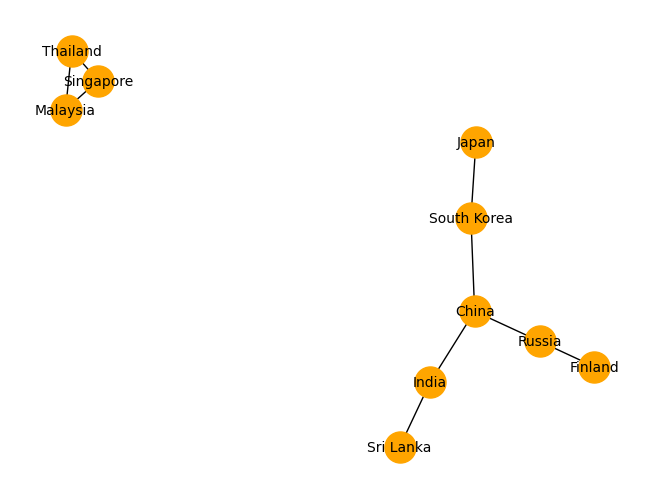

In [39]:
# Convert GraphFrame to a NetworkX graph
nx_graph = nx.from_pandas_edgelist(countries_edges.toPandas(), 'src', 'dst')

# Create a dictionary mapping node IDs to their corresponding country names
# Convert vertices to Pandas DataFrame and create node_country_mapping
node_country_mapping = countries_vertices.toPandas().set_index('id')['country'].to_dict()

# Visualize the graph
nx.draw(nx_graph, labels=node_country_mapping, node_color='orange', node_size=500, font_size=10, font_color='black')

plt.show()

## 4.3. Step 3 - Algorithm:

* Implementing the algorithm in the algorithm function using the Pregel API for graph processing.
* Iteratively send messages from each vertex to its neighbors.
  * Message is the ID of the vertex if its value is -1.
  * For each vertex collect the messages from its neighbors and update its value to be the maximum of its current value and the maximum ID in the messages, if the maximum ID is less than its own ID.
  * Stop the algorithm when there are no vertices with value -1, meaning that all vertices have found the maximum ID reachable from them.

In [35]:
# Step 3 - Algorithm

# Initialize variables for the algorithm
value = -1
superstep = 0

# Functions

# Define a function to get the maximum value
def getid_maximum(vertex_id, msgids,i,value):
    maxid = -1
    flag = False
    for id in msgids:
        flag = True
        break
    if(flag):
        maxid = max(msgids)
    if(value != -1):
        return int(value)
    return i if(int(maxid) < int(vertex_id)) else -1
getid_maximum_udf = F.udf(getid_maximum, types.IntegerType())

# Algorithm

def algorithm(g):
    i = 0
    while(True):
        # Aggregate messages for each vertex
        aggregates = g.aggregateMessages(F.collect_set(AM.msg).alias("agg"),sendToDst=F.when(AM.src['value'] == -1, AM.src["id"]))

        # Determine a new value for each vertex based on aggregated messages
        new_vertices = g.vertices.join(aggregates, on="id", how="left_outer") \
            .withColumn("newValue", getid_maximum_udf("id", "agg", lit(i), "value")) \
            .drop("agg") \
            .withColumn('max_by_rows', greatest('value', 'newValue')) \
            .drop("value", "newValue") \
            .withColumnRenamed("max_by_rows", "value")

        cached_new_vertices = AM.getCachedDataFrame(new_vertices)
        g = GraphFrame(cached_new_vertices, g.edges)
        i += 1
        print('Iteration: ', i)
        g.vertices.show()

        # Check if there are still vertices with a value of -1
        if(g.filterVertices("value == -1").dropIsolatedVertices().edges.count() == 0):
            final_df = g.vertices
            final_df = final_df.withColumn("value", F.when(final_df["value"] == -1, i).otherwise(final_df["value"]))
            break
    return final_df

## 4.4. Step 4 - Results:
Prints the elapsed time of the algorithm and the final dataframe, which shows the maximum ID reachable from each vertex.

In [36]:
# Step 4 - Result
print('Iteration 0: ')
country_graph.vertices.show()

start_time = time.time()
finaldf = algorithm(country_graph)
elapsed = time.time() - start_time

print("-----Algorithm-----")
print("---Elapsed time: " + str(elapsed))
finaldf.show()

Iteration 0: 
+---+-----------+-----+
| id|    country|value|
+---+-----------+-----+
|  1|      China|   -1|
|  2|South Korea|   -1|
|  3|      Japan|   -1|
|  4|      India|   -1|
|  5|   Malaysia|   -1|
|  6|   Thailand|   -1|
|  7|  Singapore|   -1|
|  8|  Sri Lanka|   -1|
|  9|     Russia|   -1|
| 10|    Finland|   -1|
+---+-----------+-----+

Iteration:  1
+---+-----------+-----+
| id|    country|value|
+---+-----------+-----+
|  1|      China|   -1|
| 10|    Finland|    0|
|  2|South Korea|   -1|
|  3|      Japan|    0|
|  4|      India|   -1|
|  5|   Malaysia|   -1|
|  6|   Thailand|   -1|
|  7|  Singapore|    0|
|  8|  Sri Lanka|    0|
|  9|     Russia|   -1|
+---+-----------+-----+

Iteration:  2
+---+-----------+-----+
| id|    country|value|
+---+-----------+-----+
|  1|      China|   -1|
| 10|    Finland|    0|
|  2|South Korea|    1|
|  3|      Japan|    0|
|  4|      India|    1|
|  5|   Malaysia|   -1|
|  6|   Thailand|    1|
|  7|  Singapore|    0|
|  8|  Sri Lanka|   

# 5. Graph Algorithms

## 5.1. An Example: Friends Graph

In [17]:
friends_vertices = spark.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
  ("d", "David", 29),
  ("e", "Esther", 32),
  ("f", "Fanny", 36),
  ("g", "George", 60)], ["id", "name", "age"])

friends_edges = spark.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
  ("f", "c", "follow"),
  ("e", "f", "follow"),
  ("e", "d", "friend"),
  ("d", "a", "friend"),
  ("a", "e", "friend")
], ["src", "dst", "relationship"])

# Create the initial graph
friends_graph = GraphFrame(friends_vertices, friends_edges)

friends_graph.vertices.show()
friends_graph.edges.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
|  g| George| 60|
+---+-------+---+

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
+---+---+------------+



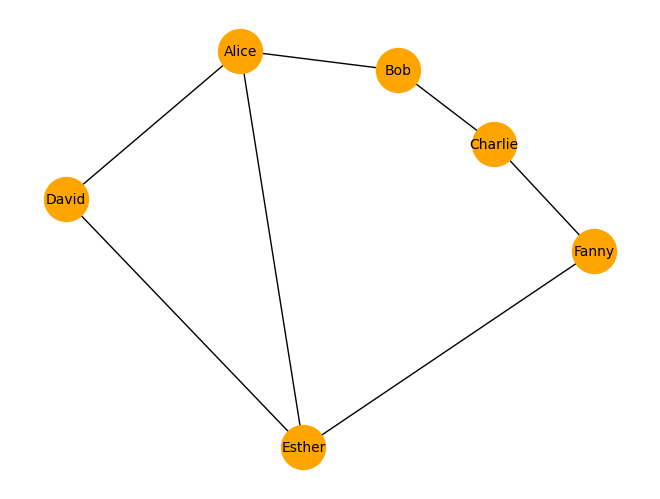

In [18]:
# Convert GraphFrame to a NetworkX graph
nx_graph = nx.from_pandas_edgelist(friends_graph.edges.toPandas(), 'src', 'dst')

# Create a dictionary mapping node IDs to their corresponding country names
# Convert vertices to Pandas DataFrame and create node_friends_mapping
node_friends_mapping = friends_graph.vertices.toPandas().set_index('id')['name'].to_dict()

# Assigning random positions for all nodes
pos = {
    'a': (7.22, 6.32),
    'b': (13.03, 6.05),
    'c': (16.55, 5.05),
    'd': (0.79, 4.29),
    'e': (9.54, 0.90),
    'f': (20.24, 3.58),
    'g': (5.78, 8.60)
}

# Visualize the graph
nx.draw(nx_graph, labels=node_friends_mapping, pos=pos, node_color='orange', node_size=1000, font_size=10, font_color='black')

plt.show()

**Note:** The node "g": George is not shown as it has neither incoming nor outgoing edges.

## 5.2. Breadth-First Search

Search from "Esther" for users of age < 32.

In [19]:
paths = friends_graph.bfs("name = 'Esther'", "age < 32")

In [20]:
paths.show()

+---------------+--------------+--------------+
|           from|            e0|            to|
+---------------+--------------+--------------+
|{e, Esther, 32}|{e, d, friend}|{d, David, 29}|
+---------------+--------------+--------------+



The search may also be limited by edge filters and maximum path lengths.


In [21]:
filteredPaths = friends_graph.bfs(
  fromExpr = "name = 'Esther'",
  toExpr = "age < 32",
  edgeFilter = "relationship != 'friend'",
  maxPathLength = 3)

filteredPaths.show()

+---------------+--------------+--------------+--------------+----------------+
|           from|            e0|            v1|            e1|              to|
+---------------+--------------+--------------+--------------+----------------+
|{e, Esther, 32}|{e, f, follow}|{f, Fanny, 36}|{f, c, follow}|{c, Charlie, 30}|
+---------------+--------------+--------------+--------------+----------------+



## 5.3. Connected Components

Compute the connected component membership of each vertex and return a DataFrame with each vertex assigned a component ID. The GraphFrames connected components implementation can take advantage of checkpointing to improve performance.

In [22]:
spark.sparkContext.setCheckpointDir("/tmp/graphframes-example-connected-components")
result = friends_graph.connectedComponents()

result.show()

+---+-------+---+------------+
| id|   name|age|   component|
+---+-------+---+------------+
|  a|  Alice| 34|412316860416|
|  b|    Bob| 36|412316860416|
|  c|Charlie| 30|412316860416|
|  d|  David| 29|412316860416|
|  e| Esther| 32|412316860416|
|  f|  Fanny| 36|412316860416|
|  g| George| 60|146028888064|
+---+-------+---+------------+



**Note:** Since, Node "g" has no outgoing or incoming edges, its connected component is different than the other nodes, which have the same component.

## 5.4. Strongly Connected Components

Compute the strongly connected component (SCC) of each vertex and return a DataFrame with each vertex assigned to the SCC containing that vertex.

In [23]:
result = friends_graph.stronglyConnectedComponents(maxIter=10)
result.show()

+---+-------+---+-------------+
| id|   name|age|    component|
+---+-------+---+-------------+
|  g| George| 60| 146028888064|
|  f|  Fanny| 36| 412316860416|
|  e| Esther| 32| 670014898176|
|  d|  David| 29| 670014898176|
|  c|Charlie| 30|1047972020224|
|  b|    Bob| 36|1047972020224|
|  a|  Alice| 34| 670014898176|
+---+-------+---+-------------+



**Note:** The component of Node "g" doesn't change. It's the same as we saw in the previous section.

## 5.5. Label Propogation Algorithm

Static Label Propagation Algorithm is used for detecting communities in networks.

* Each node in the network is initially assigned to its own community. * At every superstep, nodes send their community affiliation to all neighbors and update their state to the most frequent community affiliation of incoming messages.
* LPA is a standard community detection algorithm for graphs. It is very inexpensive computationally, although:
  * convergence is not guaranteed and
  * one can end up with trivial solutions (all nodes are identified into a single community).

In [24]:
result = friends_graph.labelPropagation(maxIter=5)
result.show()

+---+-------+---+-------------+
| id|   name|age|        label|
+---+-------+---+-------------+
|  g| George| 60| 146028888064|
|  f|  Fanny| 36|1047972020224|
|  e| Esther| 32|1460288880640|
|  d|  David| 29|1460288880640|
|  c|Charlie| 30|1382979469312|
|  b|    Bob| 36|1047972020224|
|  a|  Alice| 34|1382979469312|
+---+-------+---+-------------+



## 5.6. PageRank

Identify important vertices in a graph based on connections.

In [25]:
ranks = friends_graph.pageRank(resetProbability=0.15, maxIter=10, sourceId="a")
ranks.edges.show()
ranks.vertices.show()

+---+---+------------+------+
|src|dst|relationship|weight|
+---+---+------------+------+
|  f|  c|      follow|   1.0|
|  e|  f|      follow|   0.5|
|  e|  d|      friend|   0.5|
|  d|  a|      friend|   1.0|
|  c|  b|      follow|   1.0|
|  b|  c|      follow|   1.0|
|  a|  e|      friend|   0.5|
|  a|  b|      friend|   0.5|
+---+---+------------+------+

+---+-------+---+-------------------+
| id|   name|age|           pagerank|
+---+-------+---+-------------------+
|  g| George| 60|                0.0|
|  f|  Fanny| 36|0.03189213697274781|
|  e| Esther| 32|0.07657840357273027|
|  d|  David| 29|0.03189213697274781|
|  c|Charlie| 30| 0.3459147020846817|
|  b|    Bob| 36| 0.3366143039702568|
|  a|  Alice| 34|0.17710831642683564|
+---+-------+---+-------------------+



## 5.7. Shortest Paths

Computes shortest paths to the given set of landmark vertices, where landmarks are specified by vertex ID.

In [26]:
results = friends_graph.shortestPaths(landmarks=["a", "d"])
results.show()

+---+-------+---+----------------+
| id|   name|age|       distances|
+---+-------+---+----------------+
|  g| George| 60|              {}|
|  f|  Fanny| 36|              {}|
|  e| Esther| 32|{a -> 2, d -> 1}|
|  d|  David| 29|{a -> 1, d -> 0}|
|  c|Charlie| 30|              {}|
|  b|    Bob| 36|              {}|
|  a|  Alice| 34|{a -> 0, d -> 2}|
+---+-------+---+----------------+



## 5.8. Triangle Counts

Computes the number of triangles passing through each vertex.

In [27]:
result = friends_graph.triangleCount()
result.show()

+-----+---+-------+---+
|count| id|   name|age|
+-----+---+-------+---+
|    0|  c|Charlie| 30|
|    0|  b|    Bob| 36|
|    1|  a|  Alice| 34|
|    0|  g| George| 60|
|    0|  f|  Fanny| 36|
|    1|  e| Esther| 32|
|    1|  d|  David| 29|
+-----+---+-------+---+



**Acknowledgements**:

The tutorial is inspired by the content and images from the following references:

[1] Official GraphX Documentation that can be found [here](https://spark.apache.org/docs/latest/graphx-programming-guide.html)

[2] https://docs.databricks.com/en/_extras/notebooks/source/graphframes-user-guide-py.html